In [372]:
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv("../data/Bakery sales.csv")

df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


# Pre-procesamiento

In [373]:
# Borrar todas las filas donde la columna 'article' no tenga más de 2 caracteres
df = df[df['article'].str.len() > 2]

# Asegurarse que los nombres de los artículos estén en mayusculas
df["article"] = df["article"].str.upper()

# eliminar la primera columna
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Reemplazar los valores de la columna 'unit_price' para que estén en formato numérico
df['unit_price'] = df['unit_price'].str.replace('€', '').str.replace(',', '.').str.strip()
df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')

print(f"#2 - Cantidad de valores nulos en 'unit_price': {df['unit_price'].isnull().sum()}")

df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

print(f"#3 - Cantidad de valores nulos en 'Quantity': {df['Quantity'].isnull().sum()}")

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

display(df)

#2 - Cantidad de valores nulos en 'unit_price': 0
#3 - Cantidad de valores nulos en 'Quantity': 0


,date,time,ticket_number,article,Quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20
...,...,...,...,...,...,...
234000,2022-09-30,18:52,288911.0,COUPE,1.0,0.15
234001,2022-09-30,18:52,288911.0,BOULE 200G,1.0,1.20
234002,2022-09-30,18:52,288911.0,COUPE,2.0,0.15
234003,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,1.30


# Clasificación de productos

## Analisis ABC

In [374]:
# Calcular la demanda valorizada = Quantity * unit_price
df_abc = df.copy()

df_abc["DemandaValorizada"] = df["Quantity"] * df["unit_price"]

# ordenar el DataFrame por la nueva columna, de forma descendente
ddf_abcf = df_abc.sort_values(by="DemandaValorizada", ascending=False)

# Agrupar los prudctos por artículo y sumar la demanda valorizada
df_abc = df_abc.groupby("article")["DemandaValorizada"].sum().reset_index()
df_abc = df_abc.sort_values(by="DemandaValorizada", ascending=False)

# Calcular la demanda valorizada porcentual
total = df_abc["DemandaValorizada"].sum()
df_abc["DemandaValorizadaPorcentual"] = df_abc["DemandaValorizada"] / total * 100

# Calcular la demanda valorizada porcentual acumulada respecto a la demanda valorizada
df_abc["DemandaValorizadaPorcentualAcumulada"] = df_abc["DemandaValorizadaPorcentual"].cumsum()

# Asignar el tipo A, B, C según la demanda valorizada porcentual acumulada
def asignar_tipo(valor):
    if valor <= 80:
        return 'A'
    elif valor <= 95:
        return 'B'
    else:
        return 'C'

df_abc["Tipo"] = df_abc["DemandaValorizadaPorcentualAcumulada"].apply(asignar_tipo)

# guardar
df_abc.to_csv("../results/Bakery sales pre-pivot-ABC.csv", index=False)

# contar cuantos articulos hay de cada tipo
display(df_abc["Tipo"].value_counts().reset_index())

df_abc.head()

,Tipo,count
0,C,91
1,B,32
2,A,25


,article,DemandaValorizada,DemandaValorizadaPorcentual,DemandaValorizadaPorcentualAcumulada,Tipo
139,TRADITIONAL BAGUETTE,144756.05,25.912185,25.912185,A
56,FORMULE SANDWICH,34710.50,6.213384,32.125569,A
31,CROISSANT,33579.50,6.010928,38.136497,A
84,PAIN AU CHOCOLAT,31100.45,5.567164,43.703660,A
6,BANETTE,24555.15,4.395516,48.099177,A


## Analisis XYZ

In [375]:
# Analisis XYZ

# Para cada articulo calcular la demanda total (no valorizada) por mes
df_agrupado_mes = df.set_index("date").groupby(["article", pd.Grouper(freq="ME")])["Quantity"].sum().reset_index()

# Pivotar el DataFrame para tener los meses como columnas
df_agrupado_mes = df_agrupado_mes.pivot(index="article", columns="date", values="Quantity")

# Rellenar los meses que faltan a cada articulo con 0
df_xyz = df_agrupado_mes.fillna(0)

meses = df_xyz.columns.unique()

# Calcula el promedio de la demanda por articulo, la desviacion estandar y cuanto representa en %
df_xyz["mean"] = df_xyz.iloc[:, :].mean(axis=1)
df_xyz["std"] = df_xyz.iloc[:, :].std(axis=1)

df_xyz["std%"] = df_xyz["std"] * 100 / df_xyz["mean"]

# ignorar articulos que su promedio sea menor a 1
df_xyz = df_xyz[df_xyz["mean"] > 1]

# simla: Asignar XYZ =SI(H3<=10%;"X";SI(H3<=25%;"Y";SI(H3>=25%;"Z")))
#X = 10
#Y = 25

# Un poco mas razonable al ajustar por temporadas sería que clase Y <= 50%?
X = 25
Y = 55

def asignar_xyz(valor):
    if valor <= X:
        return 'X'
    elif valor <= Y:
        return 'Y'
    else:
        return 'Z'
    
df_xyz["XYZ"] = df_xyz["std%"].apply(asignar_xyz)

# ordernar por desviacion estandar
df_xyz = df_xyz.sort_values(by="std%", ascending=True).reset_index()

# guardar
df_xyz.to_csv("../results/Bakery sales XYZ.csv", index=False)

# contar cuantos articulos hay de cada tipo
display(df_xyz["XYZ"].value_counts().reset_index())

df_xyz

,XYZ,count
0,Z,69
1,Y,38
2,X,3


date,article,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,...,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,mean,std,std%,XYZ
0,BANETTINE,113.0,120.0,139.0,149.0,141.0,148.0,158.0,174.0,145.0,...,156.0,155.0,150.0,226.0,239.0,138.0,147.238095,32.240029,21.896527,X
1,PAIN,89.0,90.0,116.0,129.0,111.0,117.0,129.0,117.0,112.0,...,118.0,121.0,110.0,196.0,153.0,65.0,117.190476,26.030420,22.212061,X
2,CAFE OU EAU,67.0,63.0,85.0,107.0,105.0,96.0,124.0,133.0,86.0,...,81.0,99.0,104.0,120.0,117.0,61.0,92.571429,21.013763,22.700053,X
3,SANDWICH COMPLET,70.0,88.0,149.0,160.0,134.0,191.0,143.0,178.0,189.0,...,152.0,182.0,162.0,152.0,211.0,109.0,137.523810,40.556391,29.490451,Y
4,COMPLET,103.0,127.0,164.0,191.0,189.0,198.0,232.0,264.0,145.0,...,184.0,182.0,160.0,257.0,263.0,133.0,168.333333,51.081013,30.345156,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,PAIN DE MIE,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.904762,5.983348,314.125771,Z
106,DELICETROPICAL,0.0,0.0,0.0,0.0,0.0,0.0,17.0,42.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.904762,9.461223,325.714232,Z
107,BOTTEREAU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.523810,79.336306,428.293682,Z
108,ENTREMETS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.809524,8.092436,447.213595,Z


In [376]:
# Crear la tabla final: articulo, tipo ABC, tipo XYZ
df_abc_xyz = pd.merge(df_abc, df_xyz[["article", "XYZ"]], on="article")

# eliminar columnas no necesarias
df_abc_xyz = df_abc_xyz.drop(columns=["DemandaValorizada", "DemandaValorizadaPorcentual", "DemandaValorizadaPorcentualAcumulada"])

# ordernar por A y luego por XYZ
df_abc_xyz = df_abc_xyz.sort_values(by=["Tipo", "XYZ"])

# guardar
df_abc_xyz.to_csv("../results/Bakery sales final.csv", index=False)

df_abc_xyz

,article,Tipo,XYZ
0,TRADITIONAL BAGUETTE,A,Y
1,FORMULE SANDWICH,A,Y
2,CROISSANT,A,Y
3,PAIN AU CHOCOLAT,A,Y
4,BANETTE,A,Y
...,...,...,...
105,PAIN DE MIE,C,Z
106,BRIOCHETTE,C,Z
107,TROPEZIENNE FRAMBOISE,C,Z
108,MERINGUE,C,Z


## Serie de tiempo (clase A)

In [377]:
# Graficar las series de tiempo de los productos de la clase A

# Para cada articulo calcular la demanda total por semana
df_agrupado_week = df.set_index("date").groupby(["article", pd.Grouper(freq="W")])["Quantity"].sum().reset_index()

# Pivotar el DataFrame para tener las semanas como columnas
df_agrupado_week = df_agrupado_week.pivot(index="article", columns="date", values="Quantity")

# Rellenar las semanas que faltan a cada articulo con 0
df_agrupado_week = df_agrupado_week.fillna(0).reset_index()

# Filtrar los productos de la clase A, columa Tipo de df_agrupado
df_clase_A = df_abc[df_abc["Tipo"] == "A"]

# Filtrar los productos de la clase A que además sean clase X o Y
df_clase_A = df_clase_A[df_clase_A["article"].isin(df_xyz[df_xyz["XYZ"].isin(['X', 'Y'])]["article"])]

articulos_clase_A_XY = df_clase_A["article"].values

# contar cuantos productos de la clase A hay
print(f"Cantidad de articulos df_clase_A: ", len(articulos_clase_A_XY))

# unir los productos de la clase A con la demanda por dia
df_clase_A_week = df_agrupado_week[df_agrupado_week["article"].isin(articulos_clase_A_XY)]

# contar cuantos productos de la clase A hay
print(f"Cantidad de articulos df_clase_A_dia: ", df_clase_A_week["article"].nunique())

display(df_clase_A_week.head())

# guardar
df_clase_A_week.to_csv("../results/Bakery sales class A by day.csv", index=False)

Cantidad de articulos df_clase_A:  18
Cantidad de articulos df_clase_A_dia:  18


date,article,2021-01-03 00:00:00,2021-01-10 00:00:00,2021-01-17 00:00:00,2021-01-24 00:00:00,2021-01-31 00:00:00,2021-02-07 00:00:00,2021-02-14 00:00:00,2021-02-21 00:00:00,2021-02-28 00:00:00,...,2022-07-31 00:00:00,2022-08-07 00:00:00,2022-08-14 00:00:00,2022-08-21 00:00:00,2022-08-28 00:00:00,2022-09-04 00:00:00,2022-09-11 00:00:00,2022-09-18 00:00:00,2022-09-25 00:00:00,2022-10-02 00:00:00
3,BAGUETTE,81.0,165.0,168.0,160.0,167.0,145.0,164.0,190.0,275.0,...,418.0,386.0,410.0,394.0,300.0,205.0,175.0,207.0,141.0,140.0
6,BANETTE,75.0,156.0,143.0,133.0,142.0,128.0,144.0,164.0,245.0,...,404.0,496.0,531.0,471.0,337.0,234.0,205.0,176.0,167.0,142.0
11,BOULE 400G,22.0,32.0,26.0,32.0,34.0,27.0,46.0,44.0,68.0,...,92.0,93.0,132.0,90.0,63.0,40.0,40.0,49.0,37.0,27.0
22,CAMPAGNE,19.0,25.0,30.0,25.0,31.0,23.0,32.0,38.0,69.0,...,80.0,82.0,103.0,118.0,59.0,38.0,41.0,44.0,29.0,28.0
24,CEREAL BAGUETTE,35.0,47.0,47.0,35.0,50.0,43.0,35.0,72.0,118.0,...,122.0,133.0,137.0,113.0,100.0,49.0,52.0,45.0,46.0,35.0


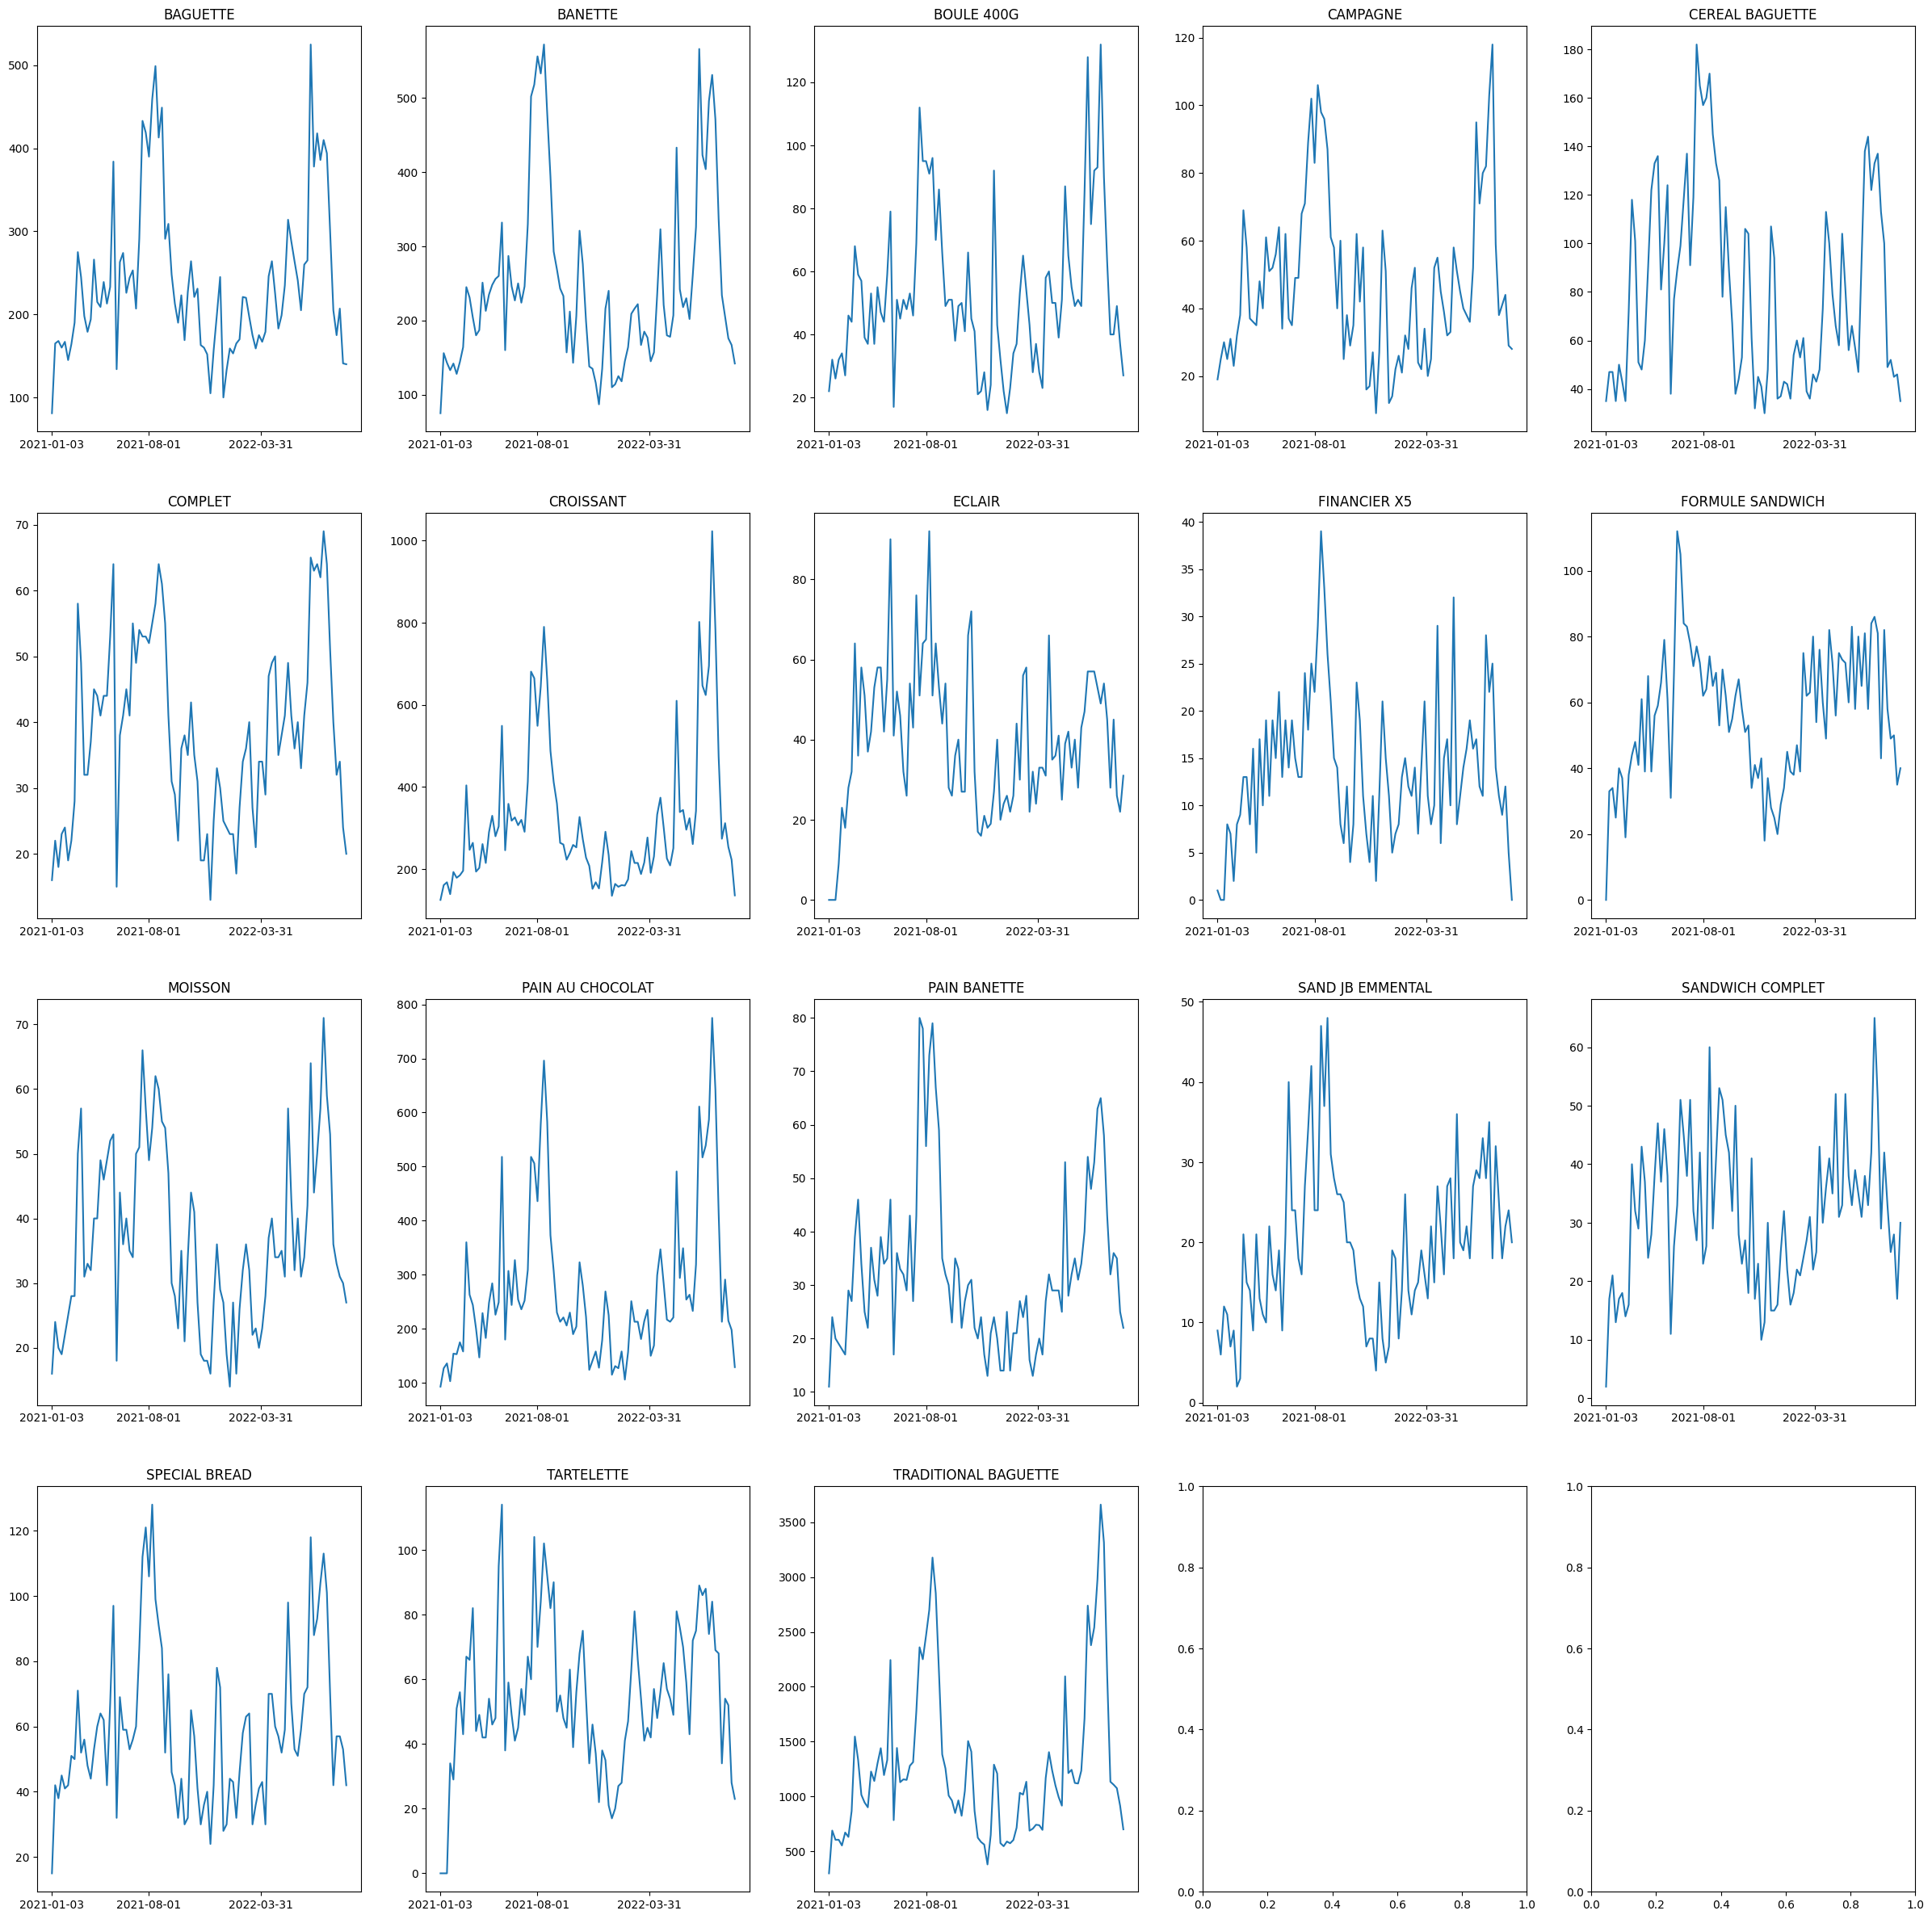

In [378]:
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

total_articulos = len(df_clase_A_week)
n_c = 5
n_f = math.ceil(total_articulos / n_c)

fig, axs = plt.subplots(n_f, n_c, figsize=(30,30))

semana_corte = pd.to_datetime("2022-03-31")

for i in range(0, len(df_clase_A_week)):
    ax = axs[i // n_c, i % n_c]
    ax.plot(df_clase_A_week.columns[1:], df_clase_A_week.iloc[i, 1:], label=df_clase_A_week.iloc[i, 0])
    ax.set_xticks([df_clase_A_week.columns[1], df_clase_A_week.columns[len(df_clase_A_week.columns)//3], semana_corte])
    ax.set_xticklabels([df_clase_A_week.columns[1], df_clase_A_week.columns[len(df_clase_A_week.columns)//3], semana_corte])
    ax.set_title(df_clase_A_week.iloc[i, 0])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

/tmp/ipykernel_31406/1045405513.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(serie_baguette.index, serie_baguette['BAGUETTE'], label="BAGUETTE", linestyle='-', marker='')


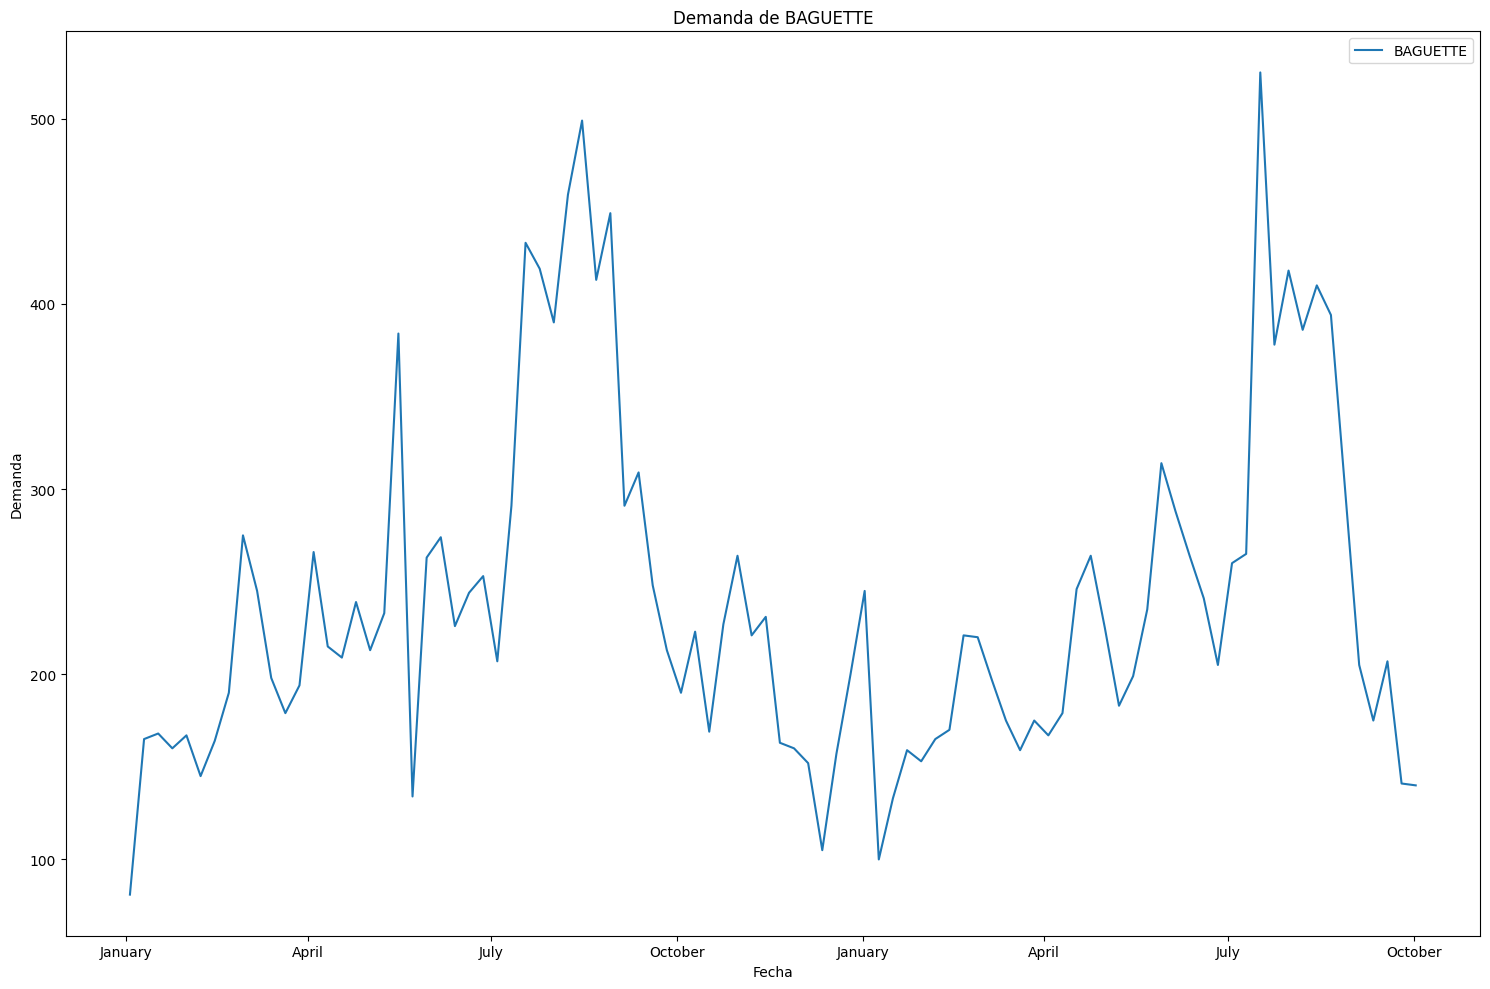

In [379]:
import matplotlib.dates as mdates

# Filtrar los datos de la serie_id "BAGUETTE"
serie_baguette = df_clase_A_week[df_clase_A_week['article'] == 'BAGUETTE'].set_index('article').T

# Convert index to DatetimeIndex
serie_baguette.index = pd.to_datetime(serie_baguette.index)

# Crear una figura para graficar la demanda de "BAGUETTE"
fig, ax = plt.subplots(figsize=(15, 10))

# Graficar la demanda de "BAGUETTE"
ax.plot_date(serie_baguette.index, serie_baguette['BAGUETTE'], label="BAGUETTE", linestyle='-', marker='')

# Formatear las etiquetas de fecha para mostrar el nombre del mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Añadir títulos y etiquetas
ax.set_title("Demanda de BAGUETTE")
ax.set_xlabel("Fecha")
ax.set_ylabel("Demanda")
ax.legend()

# Ajustar el layout
plt.tight_layout()
plt.show()


## Estacionalidad
Teniendo en cuenta las estaciones del año en Europa (ya que el precio de los articulos esta en euros), se puede hacer un analisis de la estacionalidad de los productos.
- Primavera: De finales de marzo a finales de junio
- Verano: De finales de junio a finales de septiembre
- Otoño: De finales de septiembre a finales de diciembre
- Invierno: De finales de diciembre a finales de marzo

/tmp/ipykernel_31406/1041797022.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(serie_baguette.index, serie_baguette['BAGUETTE'], label="BAGUETTE", linestyle='-', marker='')


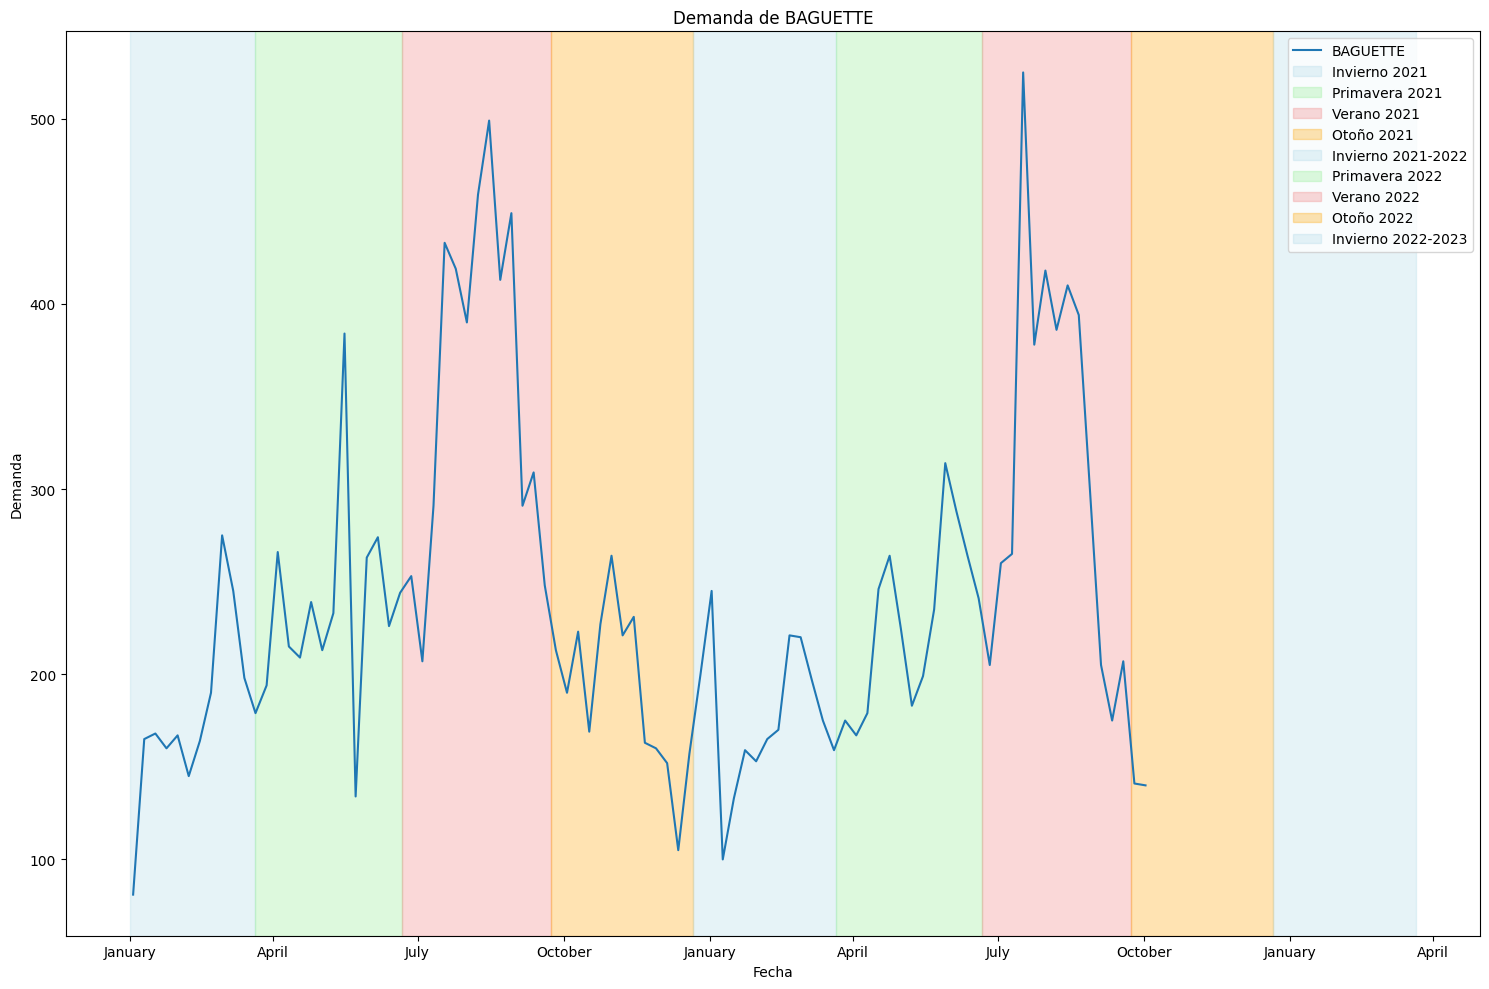

In [380]:
# Crear una figura para graficar la demanda de "BAGUETTE"
fig, ax = plt.subplots(figsize=(15, 10))

# Graficar la demanda de "BAGUETTE"
ax.plot_date(serie_baguette.index, serie_baguette['BAGUETTE'], label="BAGUETTE", linestyle='-', marker='')

# Formatear las etiquetas de fecha para mostrar el nombre del mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Añadir banda de colores desde el inicio de 2021 hasta la primavera de 2021-03
ax.axvspan(pd.to_datetime("2021-01-01"), pd.to_datetime("2021-03-21"), color='lightblue', alpha=0.3, label='Invierno 2021')

# Añadir bandas de colores para las estaciones en 2021
ax.axvspan(pd.to_datetime("2021-03-21"), pd.to_datetime("2021-06-21"), color='lightgreen', alpha=0.3, label='Primavera 2021')
ax.axvspan(pd.to_datetime("2021-06-21"), pd.to_datetime("2021-09-23"), color='lightcoral', alpha=0.3, label='Verano 2021')  
ax.axvspan(pd.to_datetime("2021-09-23"), pd.to_datetime("2021-12-21"), color='orange', alpha=0.3, label='Otoño 2021')
ax.axvspan(pd.to_datetime("2021-12-21"), pd.to_datetime("2022-03-21"), color='lightblue', alpha=0.3, label='Invierno 2021-2022')

# Añadir bandas de colores para las estaciones en 2022
ax.axvspan(pd.to_datetime("2022-03-21"), pd.to_datetime("2022-06-21"), color='lightgreen', alpha=0.3, label='Primavera 2022')
ax.axvspan(pd.to_datetime("2022-06-21"), pd.to_datetime("2022-09-23"), color='lightcoral', alpha=0.3, label='Verano 2022')  
ax.axvspan(pd.to_datetime("2022-09-23"), pd.to_datetime("2022-12-21"), color='orange', alpha=0.3, label='Otoño 2022')
ax.axvspan(pd.to_datetime("2022-12-21"), pd.to_datetime("2023-03-21"), color='lightblue', alpha=0.3, label='Invierno 2022-2023')

# Añadir títulos y etiquetas
ax.set_title("Demanda de BAGUETTE")
ax.set_xlabel("Fecha")
ax.set_ylabel("Demanda")
ax.legend()

# Ajustar el layout
plt.tight_layout()
plt.show()


# Ingredientes

In [381]:
df_clase_A_week = df_clase_A_week.set_index("article").T

# Cargar los ingredientes de los productos
df_ingredientes = pd.read_csv("../data/Ingredientes productos (A) - Ingredientes.csv", index_col=0)

df_precio = df_ingredientes["Precio"]

# Asegurarse que los nombres de los ingredientes estén en mayusculas - Como los nombres de los articulos
df_ingredientes.columns = df_ingredientes.columns.str.upper()

if len(set(df_clase_A_week.columns) - set(df_ingredientes.columns)) > 0:
    print(f"Faltan los ingredientes de los siguientes articulos: {set(df_clase_A_week.columns) - set(df_ingredientes.columns)}")

# Quitar los articulos (y otras columas residuales) de df_ingredientes que no sean clase A
df_ingredientes = df_ingredientes.drop(columns=set(df_ingredientes.columns) - set(df_clase_A_week.columns))

df_ingredientes = df_ingredientes.T

display(df_ingredientes)
display(df_clase_A_week)

Ingrediente,Harina de trigo,Sal,Levadura,Mantequilla,Azúcar,Chocolate,Emmental,Pasas,Leche
TRADITIONAL BAGUETTE,500,10,5,0,0,0,0,0,0
FORMULE SANDWICH,300,5,5,0,10,0,0,0,50
CROISSANT,250,5,0,150,20,0,0,0,20
PAIN AU CHOCOLAT,250,5,0,150,0,100,0,0,20
BANETTE,500,10,5,0,0,0,0,0,0
BAGUETTE,500,10,5,0,0,0,0,0,0
SANDWICH COMPLET,250,3,2,50,10,0,0,0,0
SPECIAL BREAD,400,10,10,100,30,0,0,0,50
TARTELETTE,150,2,0,50,50,0,0,0,50
CEREAL BAGUETTE,500,10,5,0,0,0,0,0,0


article,BAGUETTE,BANETTE,BOULE 400G,CAMPAGNE,CEREAL BAGUETTE,COMPLET,CROISSANT,ECLAIR,FINANCIER X5,FORMULE SANDWICH,MOISSON,PAIN AU CHOCOLAT,PAIN BANETTE,SAND JB EMMENTAL,SANDWICH COMPLET,SPECIAL BREAD,TARTELETTE,TRADITIONAL BAGUETTE
date,,,,,,,,,,,,,,,,,,
2021-01-03 00:00:00,81.0,75.0,22.0,19.0,35.0,16.0,125.0,0.0,1.0,0.0,16.0,93.0,11.0,9.0,2.0,15.0,0.0,299.0
2021-01-10 00:00:00,165.0,156.0,32.0,25.0,47.0,22.0,161.0,0.0,0.0,33.0,24.0,127.0,24.0,6.0,17.0,42.0,0.0,689.0
2021-01-17 00:00:00,168.0,143.0,26.0,30.0,47.0,18.0,168.0,0.0,0.0,34.0,20.0,136.0,20.0,12.0,21.0,38.0,0.0,605.0
2021-01-24 00:00:00,160.0,133.0,32.0,25.0,35.0,23.0,139.0,9.0,8.0,25.0,19.0,103.0,19.0,11.0,13.0,45.0,34.0,605.0
2021-01-31 00:00:00,167.0,142.0,34.0,31.0,50.0,24.0,193.0,23.0,7.0,40.0,22.0,154.0,18.0,7.0,17.0,41.0,29.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-04 00:00:00,205.0,234.0,40.0,38.0,49.0,40.0,274.0,28.0,11.0,58.0,36.0,213.0,32.0,25.0,33.0,42.0,34.0,1134.0
2022-09-11 00:00:00,175.0,205.0,40.0,41.0,52.0,32.0,312.0,45.0,9.0,49.0,33.0,291.0,36.0,18.0,25.0,57.0,54.0,1107.0
2022-09-18 00:00:00,207.0,176.0,49.0,44.0,45.0,34.0,254.0,26.0,12.0,50.0,31.0,215.0,35.0,22.0,28.0,57.0,52.0,1075.0


In [382]:
# Ahora el objetivo es determinar la demanda por semana de los ingredientes. Es decir,
#   date        Harina de Trigo  Levadura   Sal  ...
#   2021-01-03  10               5          2
#   2021-01-10  12               6          3
#   ...
# 
# Para ello multiplicamos la demanda de los productos por los ingredientes de cada producto
# > df.dot(other) "the column names of DataFrame and the index of other must contain the same values" - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html

df_demanda_ingrediente = df_clase_A_week.dot(df_ingredientes)

# guardar
df_demanda_ingrediente.to_csv("../results/Bakery sales ingredientes por dia.csv")

df_demanda_ingrediente.head()

Ingrediente,Harina de trigo,Sal,Levadura,Mantequilla,Azúcar,Chocolate,Emmental,Pasas,Leche
date,,,,,,,,,
2021-01-03 00:00:00,347100.0,7015.0,3024.0,36230.0,3590.0,9300.0,900.0,0.0,6900.0
2021-01-10 00:00:00,691350.0,13934.0,6539.0,50670.0,5740.0,12700.0,600.0,0.0,11870.0
2021-01-17 00:00:00,644350.0,12939.0,5977.0,52590.0,5750.0,13600.0,1200.0,0.0,11700.0
2021-01-24 00:00:00,620150.0,12478.0,5856.0,47570.0,7780.0,10750.0,1100.0,0.0,13500.0
2021-01-31 00:00:00,644250.0,12968.0,5849.0,64240.0,9360.0,16550.0,700.0,0.0,16660.0


## Analisis ABC

In [383]:
## ABC Ingredientes
df_demanda_ingrediente_abc = df_demanda_ingrediente.T.copy()

df_demanda_ingrediente_abc["DemandaTotal"] = df_demanda_ingrediente_abc.sum(axis=1)

# df_precio contiene el precio de cada ingrediente (index), por lo que usamos multiply para multiplicar cada ingrediente por su precio
df_demanda_ingrediente_abc["DemandaValorizada"] = df_demanda_ingrediente_abc["DemandaTotal"].multiply(df_precio)

# Ordenar el DataFrame por la nueva columna, de forma descendente
df_demanda_ingrediente_abc = df_demanda_ingrediente_abc.sort_values(by="DemandaValorizada", ascending=False)

# Calcular la demanda valorizada porcentual
total = df_demanda_ingrediente_abc["DemandaValorizada"].sum()
df_demanda_ingrediente_abc["DemandaValorizadaPorcentual"] = df_demanda_ingrediente_abc["DemandaValorizada"] / total * 100

df_demanda_ingrediente_abc["DemandaValorizadaPorcentualAcumulada"] = df_demanda_ingrediente_abc["DemandaValorizadaPorcentual"].cumsum()

# Asignar el tipo A, B, C según la demanda valorizada porcentual acumulada
def asignar_tipo(valor):
    if valor <= 80:
        return 'A'
    elif valor <= 95:
        return 'B'
    else:
        return 'C'

df_demanda_ingrediente_abc["Tipo"] = df_demanda_ingrediente_abc["DemandaValorizadaPorcentualAcumulada"].apply(asignar_tipo)

display(df_demanda_ingrediente_abc)

# guardar
df_demanda_ingrediente_abc.to_csv("../results/Bakery sales ingredientes ABC.csv")

# Nos quedamos con los ingredientes de clase A y B
df_demanda_ingrediente_abc = df_demanda_ingrediente_abc[df_demanda_ingrediente_abc["Tipo"].isin(["A", "B"])]

# Filtrar tambien en df_demanda_ingrediente
df_demanda_ingrediente = df_demanda_ingrediente[df_demanda_ingrediente_abc.index]

display(df_demanda_ingrediente)

date,2021-01-03 00:00:00,2021-01-10 00:00:00,2021-01-17 00:00:00,2021-01-24 00:00:00,2021-01-31 00:00:00,2021-02-07 00:00:00,2021-02-14 00:00:00,2021-02-21 00:00:00,2021-02-28 00:00:00,2021-03-07 00:00:00,...,2022-09-04 00:00:00,2022-09-11 00:00:00,2022-09-18 00:00:00,2022-09-25 00:00:00,2022-10-02 00:00:00,DemandaTotal,DemandaValorizada,DemandaValorizadaPorcentual,DemandaValorizadaPorcentualAcumulada,Tipo
Ingrediente,,,,,,,,,,,,,,,,,,,,,
Harina de trigo,347100.0,691350.0,644350.0,620150.0,644250.0,672350.0,691700.0,858550.0,1489350.0,1270500.0,...,1077800.0,1067600.0,1021150.0,857200.0,680900.0,113640400.0,6818424.00,53.562436,53.562436,A
Mantequilla,36230.0,50670.0,52590.0,47570.0,64240.0,61930.0,69140.0,68460.0,141220.0,97750.0,...,89350.0,109560.0,88140.0,76830.0,52450.0,10110040.0,4246216.80,33.356347,86.918782,B
Levadura,3024.0,6539.0,5977.0,5856.0,5849.0,6131.0,6288.0,8017.0,13350.0,11724.0,...,9816.0,9470.0,9356.0,7814.0,6385.0,1030106.0,793181.62,6.230874,93.149656,B
Chocolate,9300.0,12700.0,13600.0,10750.0,16550.0,16200.0,18900.0,17400.0,39200.0,28100.0,...,22700.0,31350.0,22800.0,20900.0,14450.0,2706300.0,649512.00,5.102271,98.251927,C
Leche,6900.0,11870.0,11700.0,13500.0,16660.0,16530.0,18220.0,18960.0,34490.0,27050.0,...,22990.0,26640.0,23300.0,18760.0,14650.0,2552420.0,127621.00,1.002532,99.254459,C
Emmental,900.0,600.0,1200.0,1100.0,700.0,900.0,200.0,300.0,2100.0,1500.0,...,2500.0,1800.0,2200.0,2400.0,2000.0,179200.0,43008.00,0.337851,99.592310,C
Azúcar,3590.0,5740.0,5750.0,7780.0,9360.0,9720.0,10960.0,11030.0,20040.0,14830.0,...,12670.0,15250.0,13250.0,10400.0,8320.0,1454810.0,29096.20,0.228567,99.820877,C
Sal,7015.0,13934.0,12939.0,12478.0,12968.0,13486.0,13975.0,17307.0,29965.0,25517.0,...,21573.0,21430.0,20481.0,17215.0,13644.0,2280213.0,22802.13,0.179123,100.000000,C
Pasas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,100.000000,C


Ingrediente,Harina de trigo,Mantequilla,Levadura
date,,,
2021-01-03 00:00:00,347100.0,36230.0,3024.0
2021-01-10 00:00:00,691350.0,50670.0,6539.0
2021-01-17 00:00:00,644350.0,52590.0,5977.0
2021-01-24 00:00:00,620150.0,47570.0,5856.0
2021-01-31 00:00:00,644250.0,64240.0,5849.0
...,...,...,...
2022-09-04 00:00:00,1077800.0,89350.0,9816.0
2022-09-11 00:00:00,1067600.0,109560.0,9470.0
2022-09-18 00:00:00,1021150.0,88140.0,9356.0


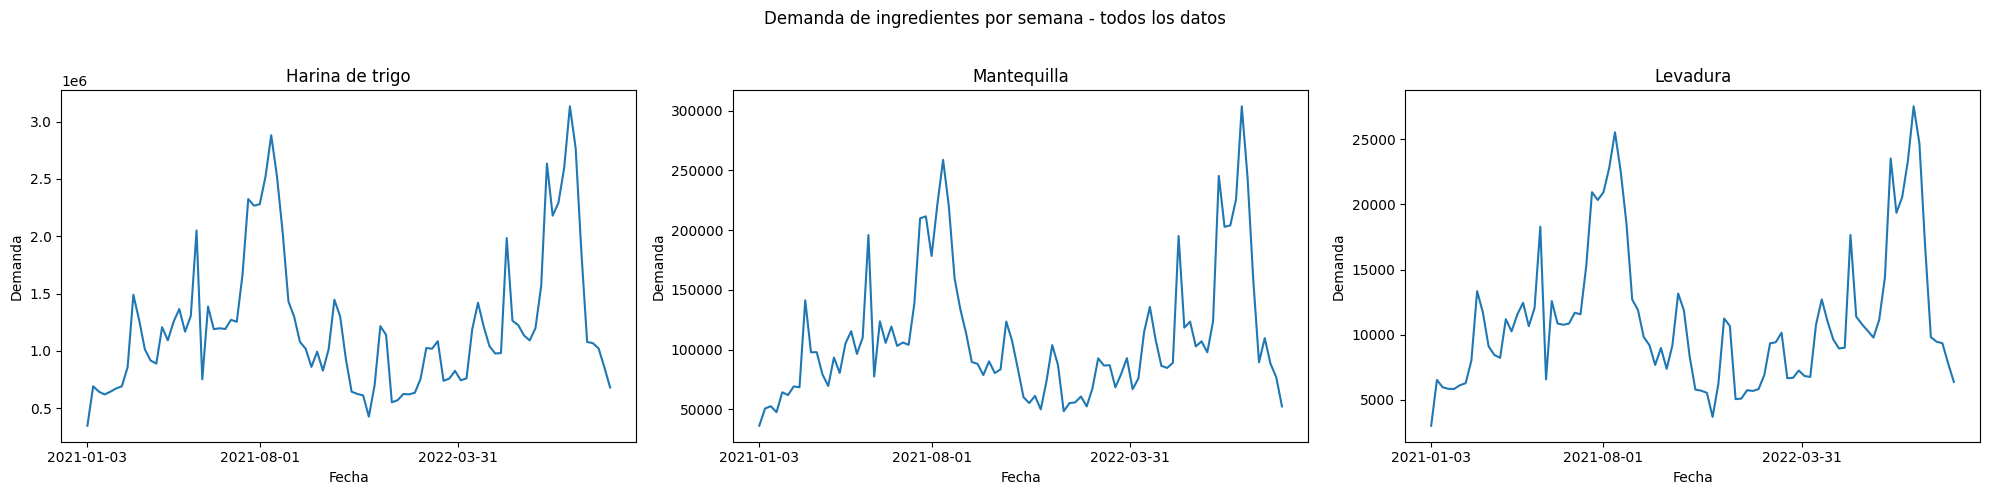

In [384]:
import math
import matplotlib.pyplot as plt

# Crear una figura con subplots
n_c = 3  # Número de columnas
n_f = math.ceil(len(df_demanda_ingrediente.columns) / n_c)  # Número de filas
fig, axs = plt.subplots(n_f, n_c, figsize=(20, 5 * n_f))
axs = axs.flatten()

# Iterar sobre cada ingrediente y graficar su demanda por semana
for i, ingrediente in enumerate(df_demanda_ingrediente.columns):
    ax = axs[i]
    ax.plot(df_demanda_ingrediente.index, df_demanda_ingrediente[ingrediente])
    ax.set_title(ingrediente)
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Demanda")
    # x label en inicio, 1/3 y fin de dato
    ax.set_xticks([df_demanda_ingrediente.index[0], df_demanda_ingrediente.index[len(df_demanda_ingrediente.index)//3], semana_corte])
    ax.set_xticklabels([df_demanda_ingrediente.index[0], df_demanda_ingrediente.index[len(df_demanda_ingrediente.index)//3], semana_corte])

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Título de la figura
fig.suptitle("Demanda de ingredientes por semana - todos los datos")
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Mostrar la figura
plt.show()

## Pronostico de demanda de ingrediente

fuente https://forecastegy.com/posts/multiple-time-series-forecasting-with-holt-winters-in-python

In [386]:
if df_demanda_ingrediente.columns[0] != "ds":
    # "StatsForecast expects the data to have at least 3 columns: ds, unique_id, and y."
    df_demanda_ingrediente = df_demanda_ingrediente.reset_index()
    df_demanda_ingrediente = df_demanda_ingrediente.rename(columns={"date": "ds"})
    df_demanda_ingrediente = df_demanda_ingrediente.melt(id_vars="ds", var_name="unique_id", value_name="y")

# "The model won’t work if you have zeros, negative, or missing values in the data."
# Reemplazar los ceros por el promedio de los dos valores anteriores y siguientes
# > interpolate: "Fill NaN values using an interpolation method"
df_demanda_ingrediente['y'] = df_demanda_ingrediente['y'].replace(0, pd.NA)
df_demanda_ingrediente['y'] = df_demanda_ingrediente['y'].interpolate(method='linear')

# Verificar si hay valores 0 en la columna 'y'
if (df_demanda_ingrediente['y'] == 0).any():
    print("Hay valores cero en la columna 'y'")

# Ordenar por la columna 'ds'
df_demanda_ingrediente = df_demanda_ingrediente.sort_values(by="ds")

# Asegurarse de que 'ds' sea de tipo datetime
df_demanda_ingrediente['ds'] = pd.to_datetime(df_demanda_ingrediente['ds'])

df_demanda_ingrediente.head()


,ds,unique_id,y
0,2021-01-03,Harina de trigo,347100.0
184,2021-01-03,Levadura,3024.0
92,2021-01-03,Mantequilla,36230.0
1,2021-01-10,Harina de trigo,691350.0
185,2021-01-10,Levadura,6539.0


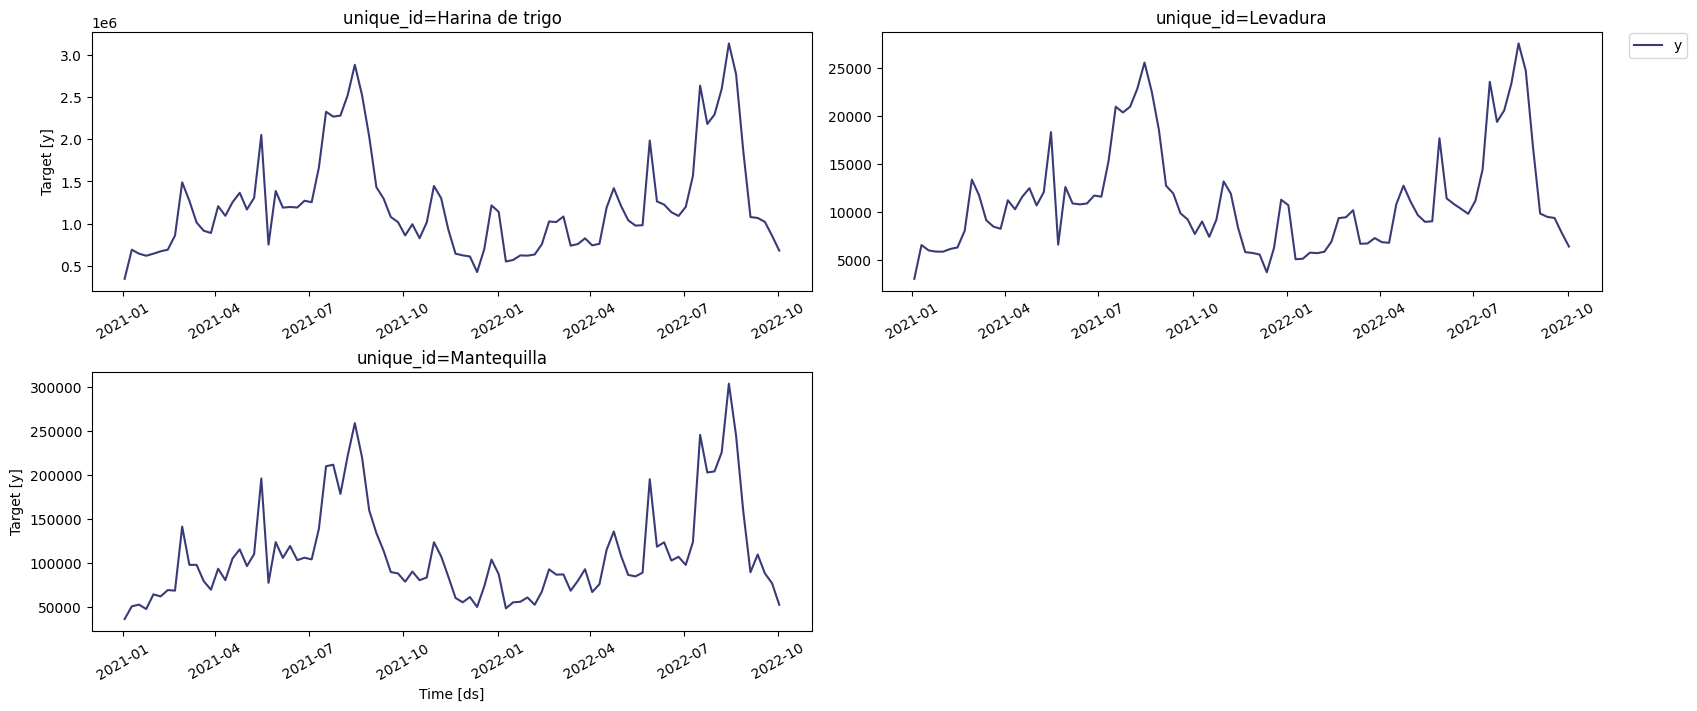

In [366]:
from statsforecast import StatsForecast

StatsForecast.plot(df_demanda_ingrediente)

In [55]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# periodos = [7, 14, 30, 60, 90, 150, 210, 270] 
# decompositions = {}
# for period in periodos:
#     decompositions[period] = seasonal_decompose(
#         df_demanda_ingrediente.loc[df_demanda_ingrediente["unique_id"] == "Sal"]["y"],
#         model="additive",
#         period=period
#     )

# fig, axs = plt.subplots(len(periodos), 4, figsize=(30, 5 * len(periodos)))

# for row, period in enumerate(periodos):
#     decompositions[period].observed.plot(ax=axs[row, 0], title=f'Observed (Periodo={period})')
#     decompositions[period].trend.plot(ax=axs[row, 1], title=f'Trend (Periodo={period})')
#     decompositions[period].seasonal.plot(ax=axs[row, 2], title=f'Seasonal (Periodo={period})')
#     decompositions[period].resid.plot(ax=axs[row, 3], title=f'Residual (Periodo={period})')

# plt.tight_layout()
# plt.show()


> For example, data with daily observations might have a weekly seasonality (frequency=7) or an annual seasonality (frequency=365.25)
>
> https://robjhyndman.com/hyndsight/seasonal-periods/

In [387]:
# los datos van desde 2021-01-02 a 2022-09-30. En 2022 solo tengo 3 trimestres por lo que tomo los ultimos 2 para validación. 
# Es decir, comienzo en 2021-01-02 y termino en 2022-03-31
datos_entrenamiento = df_demanda_ingrediente.loc[df_demanda_ingrediente["ds"] <= "2022-03-31"]
datos_verificacion = df_demanda_ingrediente.loc[df_demanda_ingrediente["ds"] > "2022-03-31"]

# total muestras para verifiacion
h = datos_verificacion['ds'].nunique()

print(f"h={h}")

from statsforecast import StatsForecast
from statsforecast.models import HoltWinters

model = StatsForecast(models=[HoltWinters(season_length=52, error_type='A', alias='HW_A'),
                              HoltWinters(season_length=52, error_type='M', alias='HW_M')], 
                              freq='W', n_jobs=-1)
model.fit(datos_entrenamiento)

p = model.predict(h=h, level=[90])

p = p.reset_index().merge(datos_verificacion, on=['ds', 'unique_id'], how='left')

p.reset_index().head()

h=27


/home/ez/projects/python/Operativa/io-abc-xyz/.venv/lib/python3.10/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,index,unique_id,ds,HW_A,HW_A-lo-90,HW_A-hi-90,HW_M,HW_M-lo-90,HW_M-hi-90,y
0,0,Harina de trigo,2022-04-03,1.183387e+06,690488.706829,1.676285e+06,1.185658e+06,582723.712625,1.788592e+06,743400.0
1,1,Harina de trigo,2022-04-10,1.068987e+06,576083.696646,1.561890e+06,1.079330e+06,476396.096841,1.682264e+06,760900.0
2,2,Harina de trigo,2022-04-17,1.230273e+06,737363.804839,1.723183e+06,1.234011e+06,631077.071412,1.836945e+06,1189800.0
3,3,Harina de trigo,2022-04-24,1.342399e+06,849482.294078,1.835316e+06,1.338799e+06,735865.189028,1.941734e+06,1419950.0
4,4,Harina de trigo,2022-05-01,1.143051e+06,650125.111520,1.635977e+06,1.138008e+06,535073.663092,1.740942e+06,1211400.0


/tmp/ipykernel_31406/684607459.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p['y'] = p['y'].fillna(method='ffill')



Resultados de la validación:
	HW_A MAPE: 18.12%
	HW_M MAPE: 18.25%

Mejor MAPE entre aditivo y multiplicativo es HW_A con 18.12%


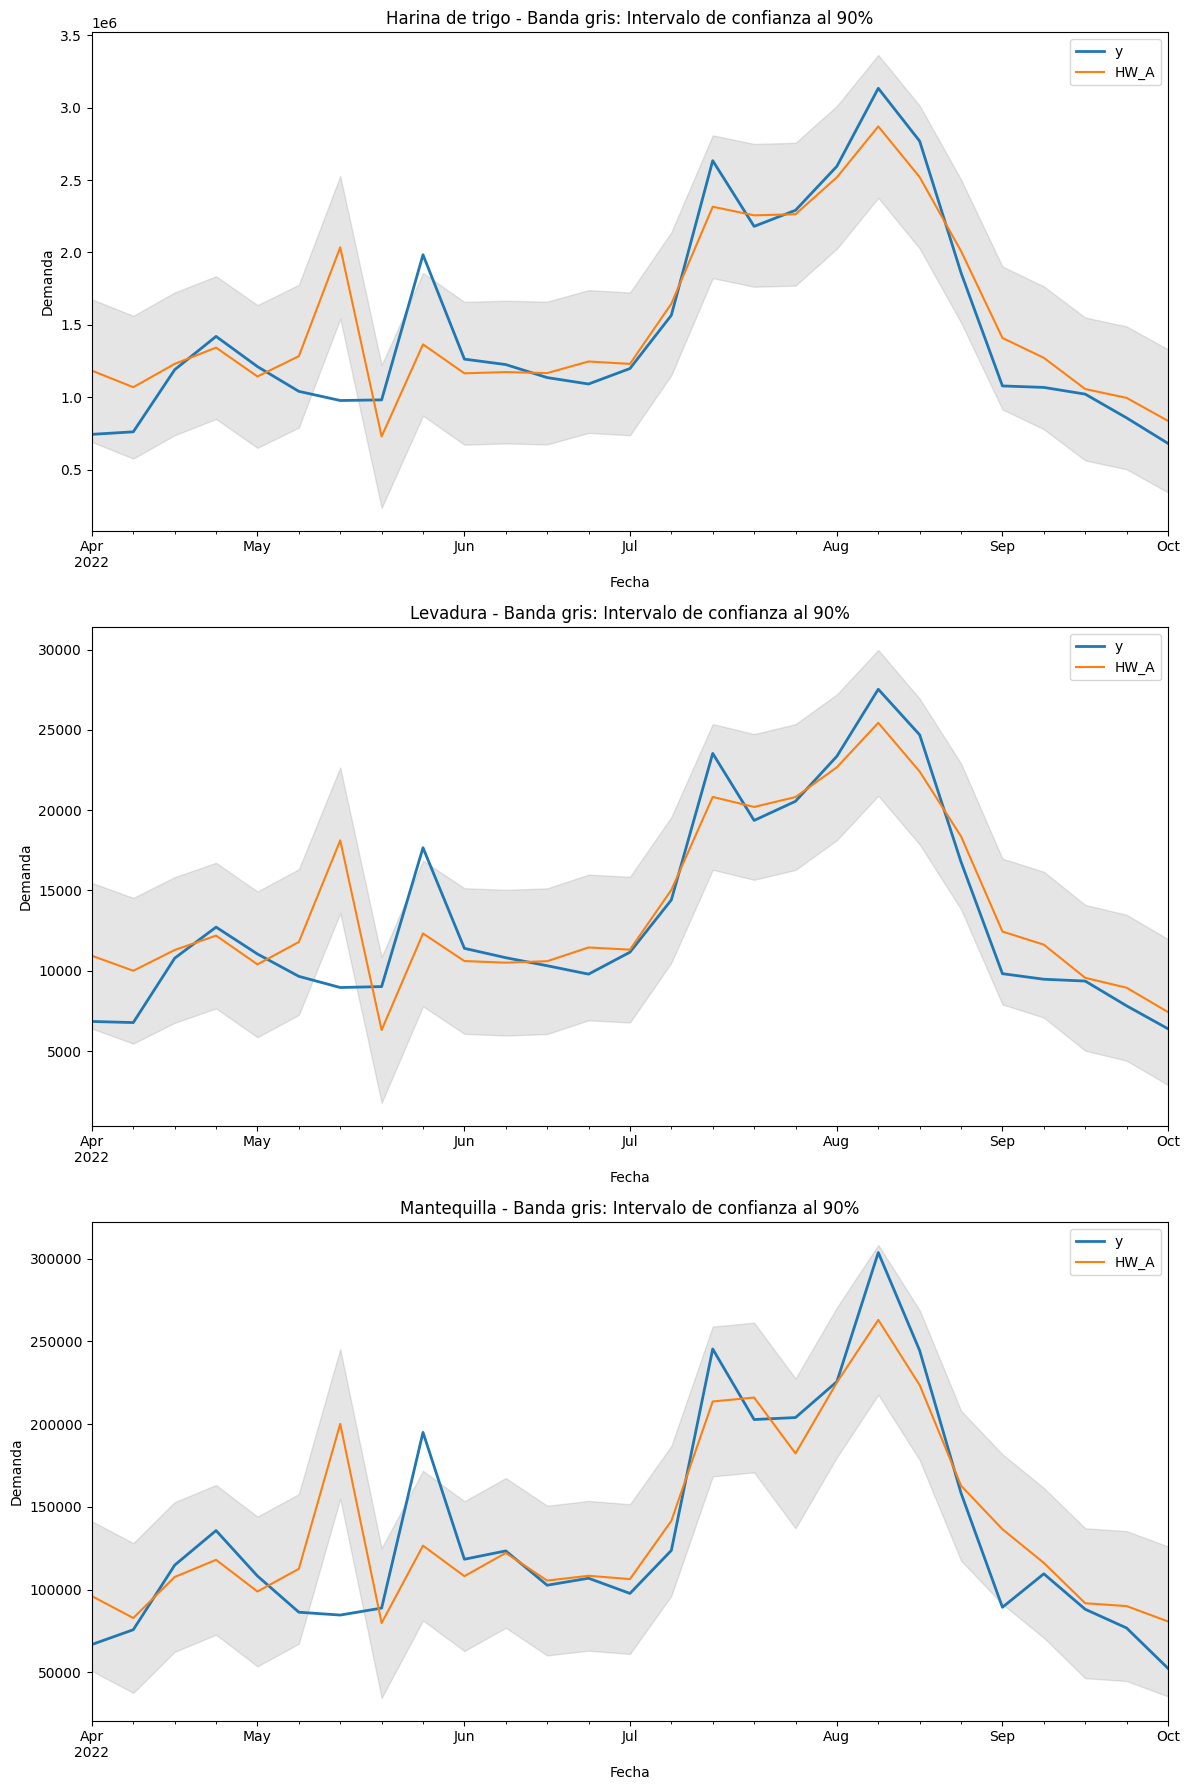

In [388]:
# Rellenar los valores faltantes en la verificacion con el último valor conocido
p['y'] = p['y'].fillna(method='ffill')

from sklearn.metrics import mean_absolute_percentage_error

unique_ids = p['unique_id'].unique()
num_unique_ids = len(unique_ids)

model_mape_ = {model_: mean_absolute_percentage_error(p['y'], p[model_]) for model_ in ['HW_A', 'HW_M']}
model_, mape_ = min(model_mape_.items(), key=lambda x: x[1])

print(f'\nResultados de la validación:')

for a, b in model_mape_.items():
    print(f'\t{a} MAPE: {b:.2%}')

print(f'\nMejor MAPE entre aditivo y multiplicativo es {model_} con {mape_:.2%}')

#for model_ in ['HW_A', 'HW_M']:
#print(f'{model_} MAPE: {mape_:.2%}')
fig, ax = plt.subplots(num_unique_ids, 1, figsize=(12, 6 * num_unique_ids))  # Increase height
for ax_, device in enumerate(unique_ids):
    p_device = p[p['unique_id'] == device]
    p_device.plot(x='ds', y='y', ax=ax[ax_], label='y', title=device, linewidth=2)
    p_device.plot(x='ds', y=model_, ax=ax[ax_], label=model_)
    ax[ax_].set_xlabel('Fecha')
    ax[ax_].set_ylabel('Demanda')
    ax[ax_].fill_between(p_device['ds'].values,
                            p_device[f'{model_}-lo-90'], 
                            p_device[f'{model_}-hi-90'], 
                            alpha=0.2,
                            color='gray')
    ax[ax_].set_title(f'{device} - Banda gris: Intervalo de confianza al 90%')
    ax[ax_].legend()
fig.tight_layout()
plt.show()

# Probando diferentes modelos

Vamos a descomponer la serie de tiempo de la demanda de ingredientes en sus componentes: tendencia, estacionalidad y residuo.

In [61]:
serie_id = "Harina de trigo"
serie_verificacion = datos_verificacion[datos_verificacion["unique_id"] == serie_id].set_index("ds")["y"]
serie_verificacion.head()

ds
2022-04-03     743400.0
2022-04-10     760900.0
2022-04-17    1189800.0
2022-04-24    1419950.0
2022-05-01    1211400.0
Name: y, dtype: float64

## Suavizado exponencial
Media móvil ponderada exponencialmente

/home/ez/projects/python/Operativa/io-abc-xyz/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


SES MAPE: 36.89%


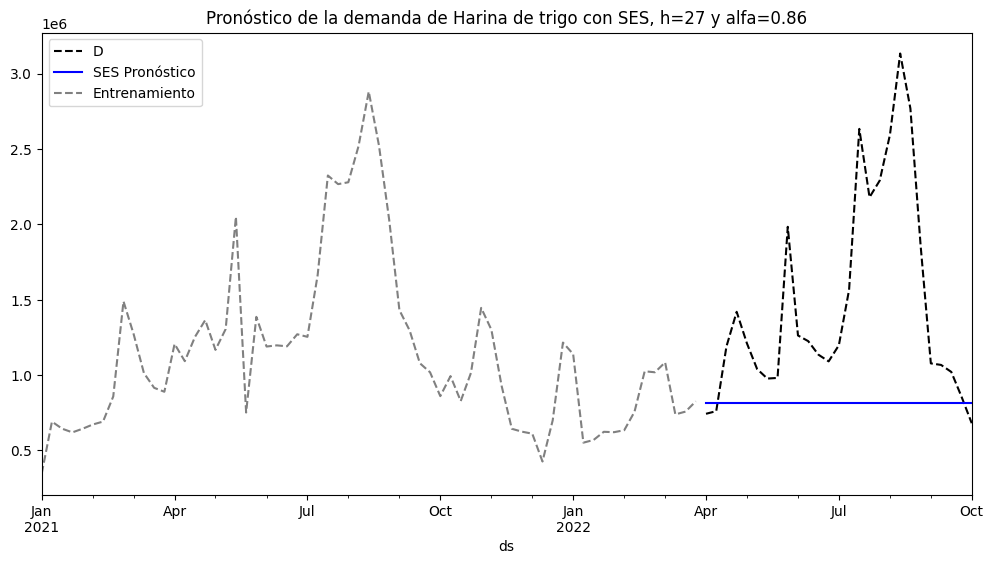

In [62]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

serie = datos_entrenamiento[datos_entrenamiento["unique_id"] == serie_id].set_index("ds")["y"]
serie.index = pd.DatetimeIndex(serie.index).to_period('W')

ses_model = SimpleExpSmoothing(serie).fit()
ses_pronostico = ses_model.forecast(steps=h)

# Calcular el MAPE
e = mean_absolute_percentage_error(serie_verificacion, ses_pronostico)
print(f"SES MAPE: {e:.2%}")

# plot
fig, ax = plt.subplots(figsize=(12, 6))
serie_verificacion.plot(ax=ax, color='black', linestyle='--', label='D')
ses_pronostico.plot(ax=ax, color='blue', label='SES Pronóstico')
serie.plot(ax=ax, linestyle='--', color='gray', label='Entrenamiento')
ax.legend()
ax.set_title(f'Pronóstico de la demanda de {serie_id} con SES, h={h} y alfa={ses_model.model.params["smoothing_level"]:.2f}')
plt.show()

## Holt
Modelo de tendencia, extensión del suavizado exponencial.

/home/ez/projects/python/Operativa/io-abc-xyz/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt MAPE: 40.68%


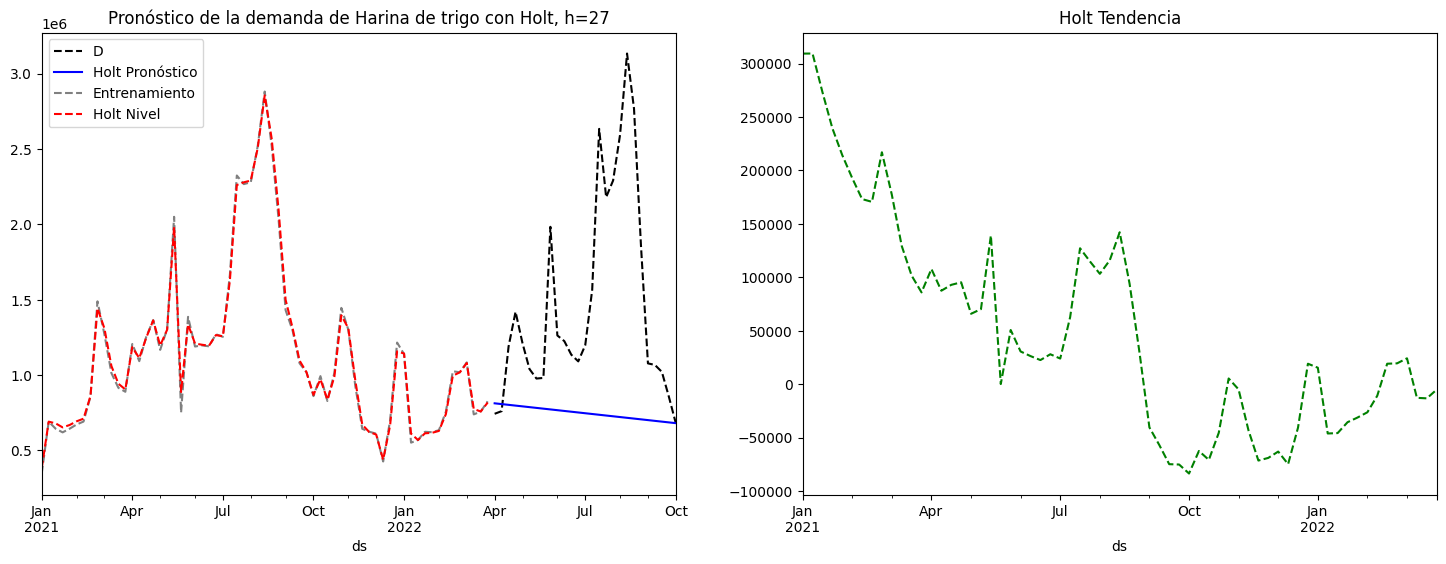

In [63]:
from statsmodels.tsa.holtwinters import Holt

holt_modelo = Holt(serie).fit()

holt_pronostico = holt_modelo.forecast(steps=h)

# Calcular el MAPE
e = mean_absolute_percentage_error(serie_verificacion, holt_pronostico)
print(f"Holt MAPE: {e:.2%}")

# plot
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
serie_verificacion.plot(ax=ax, color='black', linestyle='--', label='D')
holt_pronostico.plot(ax=ax, color='blue', label='Holt Pronóstico')
serie.plot(ax=ax, linestyle='--', color='gray', label='Entrenamiento')
holt_modelo.level.plot(ax=ax, color='red', linestyle='--', label='Holt Nivel')
ax.legend()
ax.set_title(f'Pronóstico de la demanda de {serie_id} con Holt, h={h}')

holt_modelo.trend.plot(ax=ax2, color='green', linestyle='--', label='Holt Tendencia')
ax2.set_title(f'Holt Tendencia')

plt.show()

## Holt-Winters
Modelo estacional, extiende el modelo de Holt.

/home/ez/projects/python/Operativa/io-abc-xyz/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


HWES MAPE: 152.80%


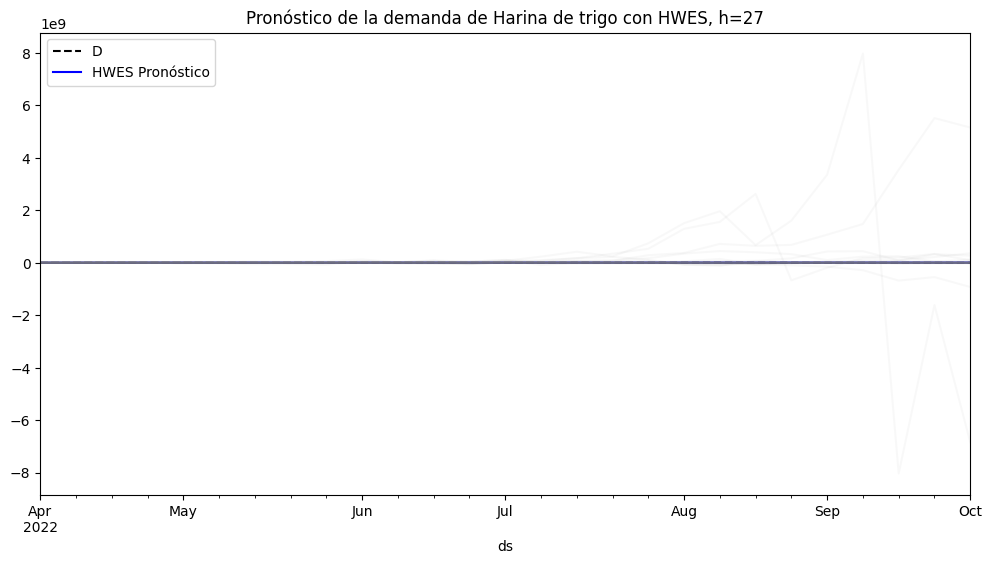

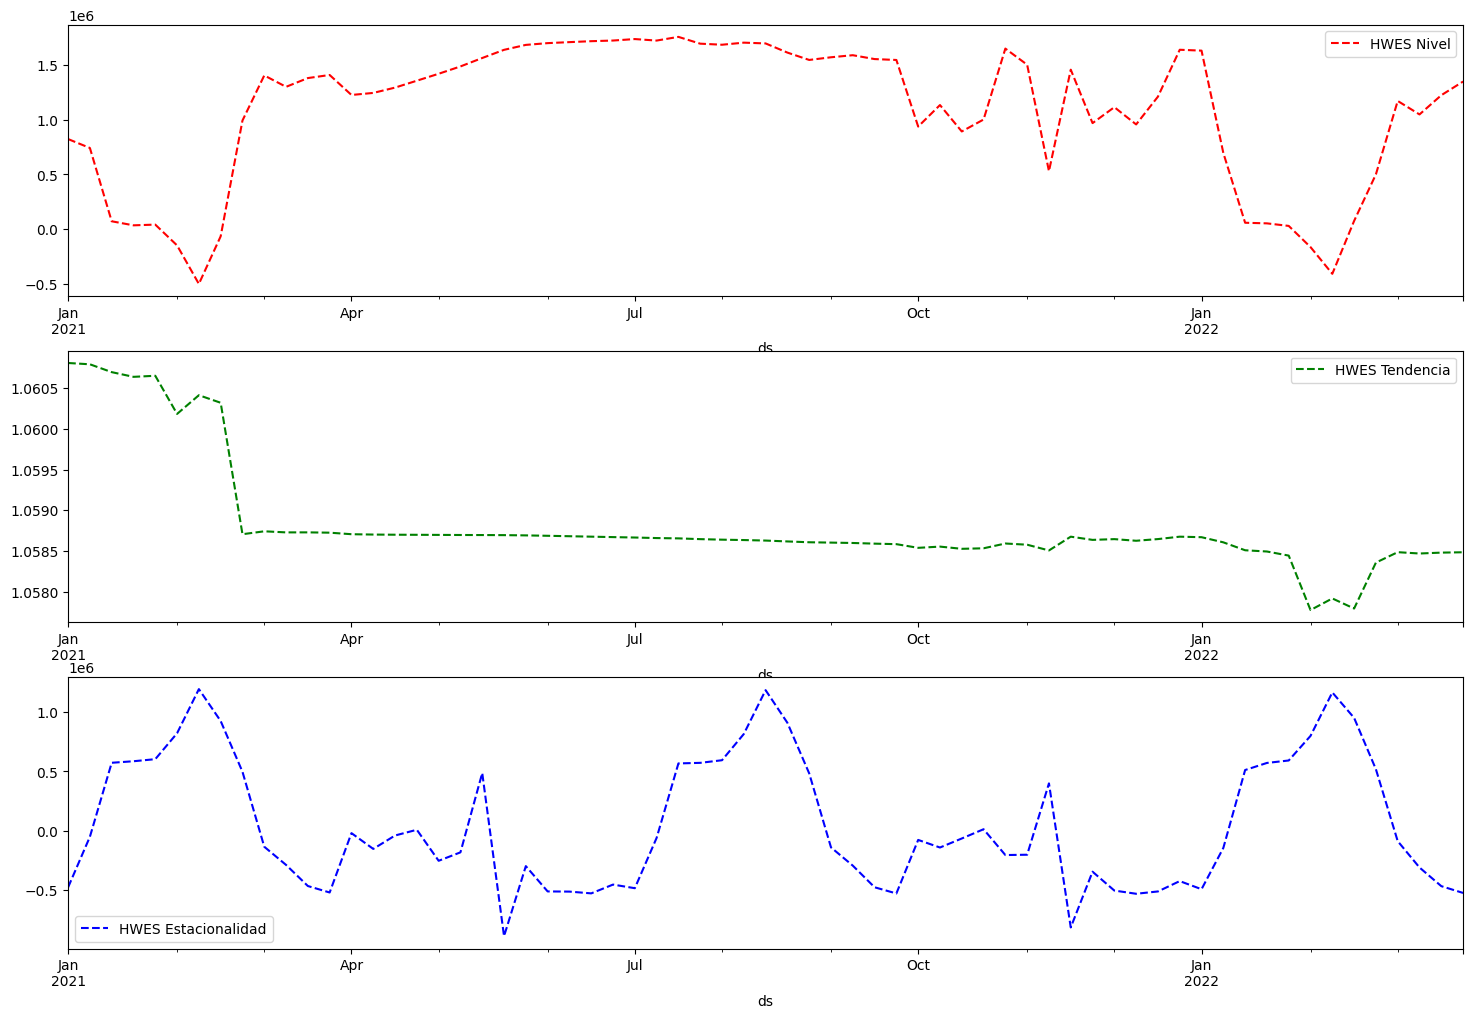

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hwes_model = ExponentialSmoothing(
        serie, 
        seasonal='add', 
        trend="mul",
        seasonal_periods=26, 
        initialization_method="estimated",
        #use_boxcox=True
        ).fit()

hwes_forecast = hwes_model.forecast(steps=h)

# interavlo de confianza
simulations = hwes_model.simulate(h, repetitions=50, error="mul")
# filter only the last h steps
simulations = simulations[simulations.index > serie.index[-1]]

# Calcular el MAPE
e = mean_absolute_percentage_error(serie_verificacion, hwes_forecast)
print(f"HWES MAPE: {e:.2%}")

# plot
fig, ax = plt.subplots(figsize=(12, 6))
serie_verificacion.plot(ax=ax, color='black', linestyle='--', label='D')
hwes_forecast.plot(ax=ax, color='blue', label='HWES Pronóstico')
ax.legend()
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
#serie.plot(ax=ax, linestyle='--', color='gray', label='Entrenamiento')
ax.set_title(f'Pronóstico de la demanda de {serie_id} con HWES, h={h}')
plt.show()

# plot level, trend, seasonal
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))
hwes_model.level.plot(ax=ax, color='red', linestyle='--', label='HWES Nivel')
hwes_model.trend.plot(ax=ax2, color='green', linestyle='--', label='HWES Tendencia')
hwes_model.season.plot(ax=ax3, color='blue', linestyle='--', label='HWES Estacionalidad')
ax.legend()
ax2.legend()
ax3.legend()
plt.show()

In [65]:
# Pronosticar la demanda hasta el fin de 2022 usando StatsForecast

# Definir el horizonte de pronóstico
h = (pd.to_datetime("2022-12-31") - datos_verificacion["ds"].max()).days

# Ajustar el modelo con todos los datos disponibles
model.fit(df_demanda_ingrediente)

# Realizar el pronóstico
forecast = model.predict(h=h)

# Mostrar los primeros resultados del pronóstico
forecast.reset_index().head()

/home/ez/projects/python/Operativa/io-abc-xyz/.venv/lib/python3.10/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,HW_A,HW_M
0,Harina de trigo,2022-10-09,9.210581e+05,9.385825e+05
1,Harina de trigo,2022-10-16,7.564383e+05,7.744061e+05
2,Harina de trigo,2022-10-23,9.380286e+05,9.531231e+05
3,Harina de trigo,2022-10-30,1.367205e+06,1.333113e+06
4,Harina de trigo,2022-11-06,1.222175e+06,1.210965e+06


In [66]:
# Componer un dataframe final con todos los datos desde el inicio hasta el fin (existentes + pronóstico)

# Concatenar los datos de entrenamiento, verificación y pronóstico
forecast['y'] = forecast['HW_A'] 
forecast = forecast.drop(columns=['HW_A', 'HW_M', 'HW_A-lo-90', 'HW_A-hi-90', 'HW_M-lo-90', 'HW_M-hi-90'], errors='ignore')
df_final = pd.concat([datos_entrenamiento, datos_verificacion, forecast])

# Ordenar por fecha y artículo
df_final = df_final.sort_values(by=["unique_id", "ds"])

# Guardar el dataframe final en un archivo CSV
df_final.to_csv("../results/Bakery sales final with forecast.csv", index=False)

df_final

,ds,unique_id,y
0,2021-01-03,Harina de trigo,3.471000e+05
1,2021-01-10,Harina de trigo,6.913500e+05
2,2021-01-17,Harina de trigo,6.443500e+05
3,2021-01-24,Harina de trigo,6.201500e+05
4,2021-01-31,Harina de trigo,6.442500e+05
...,...,...,...
Levadura,2024-06-16,NaN,8.667809e+03
Mantequilla,2024-06-16,NaN,1.002338e+05
Harina de trigo,2024-06-23,NaN,1.043228e+06
Levadura,2024-06-23,NaN,9.428394e+03


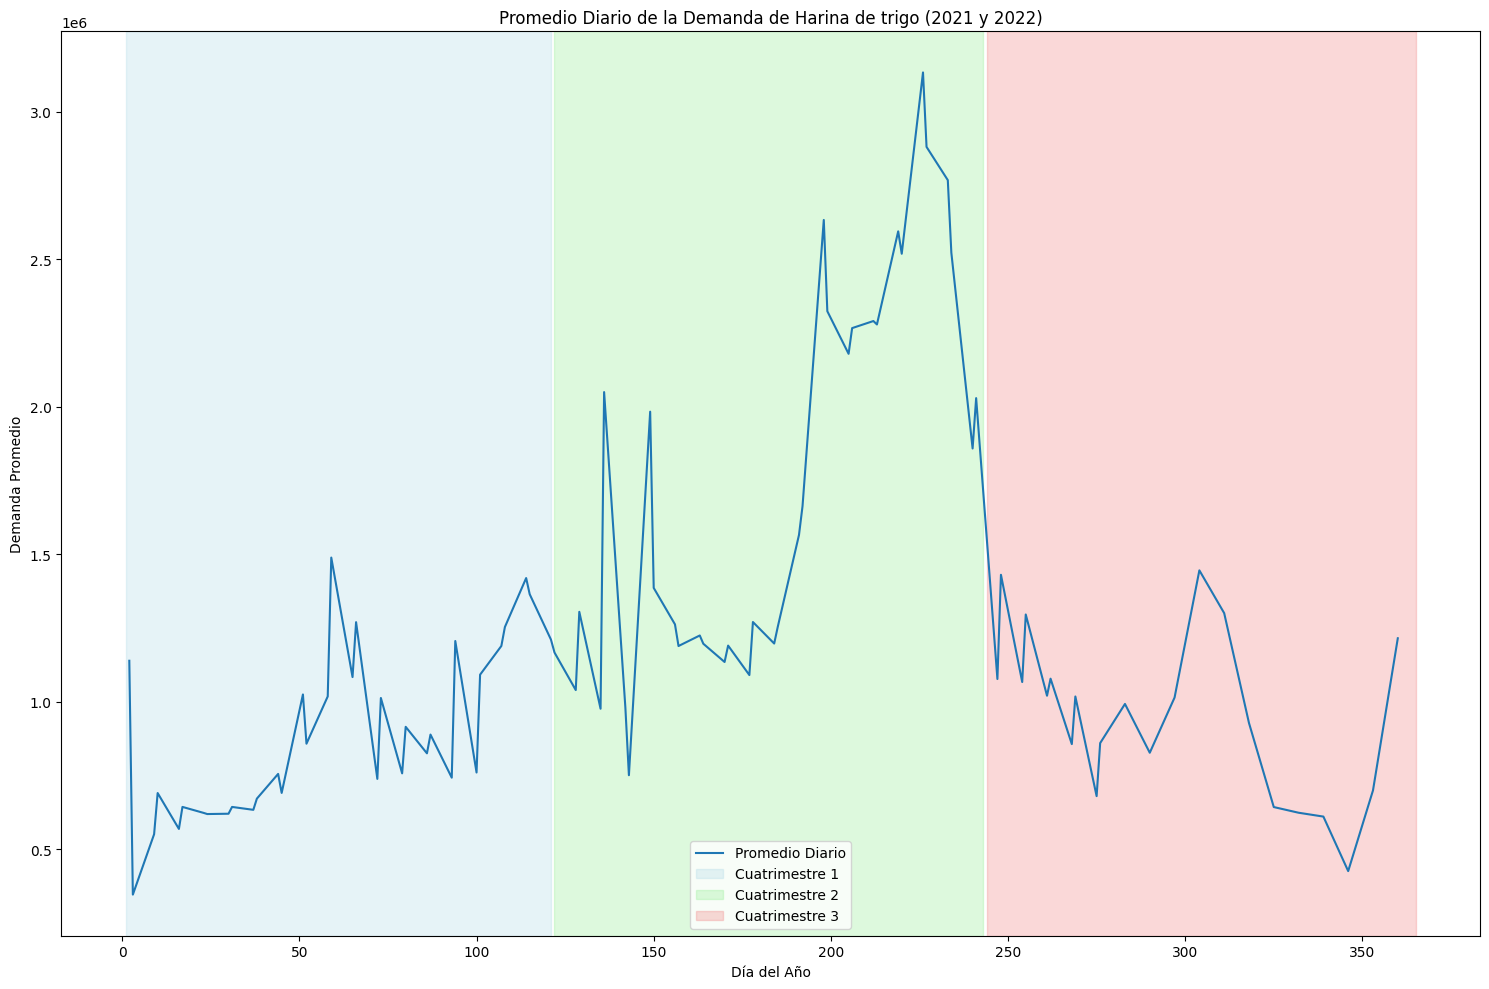

In [67]:
# Separar gráficamente la demanda en ventanas cuatrimestrales para una serie_id

# Definir la serie_id a utilizar
serie_id = "Harina de trigo"

# Filtrar los datos de la serie_id
serie = df_final[df_final["unique_id"] == serie_id].set_index("ds")["y"]

# Crear una nueva columna 'day_of_year' que representa el día del año (1 a 365)
serie.index = pd.to_datetime(serie.index)
serie = serie.reset_index()
serie['day_of_year'] = serie['ds'].dt.dayofyear

# Calcular el promedio de la demanda diaria para cada día del año
promedio_diario = serie.groupby('day_of_year')['y'].mean()

# Crear una figura para graficar el promedio diario
fig, ax = plt.subplots(figsize=(15, 10))

# Graficar el promedio diario
ax.plot(promedio_diario.index, promedio_diario.values, label="Promedio Diario")

# Añadir bandas de colores para los cuatrimestres
ax.axvspan(1, 121, color='lightblue', alpha=0.3, label='Cuatrimestre 1')
ax.axvspan(122, 243, color='lightgreen', alpha=0.3, label='Cuatrimestre 2')
ax.axvspan(244, 365, color='lightcoral', alpha=0.3, label='Cuatrimestre 3')

# Añadir títulos y etiquetas
ax.set_title(f"Promedio Diario de la Demanda de {serie_id} (2021 y 2022)")
ax.set_xlabel("Día del Año")
ax.set_ylabel("Demanda Promedio")
ax.legend()

# Ajustar el layout
plt.tight_layout()
plt.show()

# guardar total
promedio_diario.to_csv("../results/Bakery sales final with forecast.csv", index=False)

# guardar cuatrimestres
promedio_diario[:121].to_csv("../results/Bakery sales final with forecast 1.csv", index=False)
promedio_diario[122:243].to_csv("../results/Bakery sales final with forecast 2.csv", index=False)
promedio_diario[244:].to_csv("../results/Bakery sales final with forecast 3.csv", index=False)


Se podría considerar que la demanda de harina de trigo tiene una demanda normal en los cuatrimestres 1 y 3, y una demanda alta en el cuatrimestre 2.

# Modelo de inventario

En octave realizamos la implementación de un modelo de inventario estocástico.

```Matlab
# function [q, SR] = Estocastico(k, c1, c2, D, Ex, cbSRi, cbSi, eps, max_i)
# D     = E[d] o si es uniforme/constante D = d
# Ex    = E[x]
# cbSRi = funcion que toma un valor q y devuelve un valor real
# cbSi  = funcion que toma un valor SR y devuelve un valor real
# eps   = |SRi+1 - SRi| <= eps
# max_i = maxima cantidad de iteraciones
function [q, SR] = Estocastico(k, c1, c2, D, Ex, cbSRi, cbSi, eps, max_i)
  ux = Ex;
  
  disp("Iniciando...")
   
  q_circunflejo = c2*D/c1
  q_hat = (2*D*(k+c2*Ex)/c1)^0.5
  
  printf("¿Tiene solución? %s\n", mat2str(q_circunflejo >= q_hat))
  
  qi = 0;
  SRi = 0;
  Si = 0;
  
  i = 1;
  while (i <= max_i)    
    qi = (2*D*(k+c2*Si)/c1)**0.5;
    
    prevSRi = SRi;
    SRi = cbSRi(qi);
    Si = cbSi(SRi);
    
    printf("Iteracion: %d\tq%d=%f\tSR%d=%f\tS%d=%f\n",i,i,qi,i,SRi,i,Si);
    
    if (abs(SRi-prevSRi) <= eps)
      printf("Se detiene: |SRi - SRi+1| <= e  (%f <= %f)\n", abs(SRi-prevSRi), eps)
      break;
    endif
    
    i++;
  endwhile
  
  if (i > 1000)
    disp("Se detiene: se realizó mas de mil iteraciones sin éxito")
  endif
  
  q = qi;
  SR = SRi;
  
endfunction
```